In [61]:
"""BubblePlot Functions"""

def generate_contig_list(samtools_index_file):
    """Generate a list of contigs from samtools index file"""
    contig_list = []
    with open(samtools_index_file) as file:
        for line in file:
            line = line.rstrip("\n")
            fields = line.split("\t")
            contig_list.append(fields[0])
    return contig_list

def generate_coverage_dict(coverage_bed_file, contig_list, gc_content_file, samtools_index_file):
    """Generate a dictionary with contigs as keys, and values of coverage, gc content, and length"""
    from statistics import mean 
    coverage_dict = {}
    with open(coverage_bed_file) as file:
        contig = ""
        coverages = []
        for line in file:
            line = line.rstrip("\n")
            fields = line.split("\t")
            if fields[0] in contig_list:
                if contig == fields[0]:
                    coverages.append(int(fields[3]))
                else:
                    if contig == "":
                        contig = fields[0]
                    else:
                        coverage_dict[contig] = [mean(coverages)]
                        contig = fields[0]
                        coverages = []
        coverage_dict[contig] = [mean(coverages)]
        contig = fields[0]

    with open(gc_content_file) as file:
        for line in file:
            line = line.rstrip("\n")
            fields = line.split("\t")
            if fields[0] in contig_list:
                coverage_dict[fields[0]].append(float(fields[1]))
    with open(samtools_index_file) as file:
        for line in file:
            line = line.rstrip("\n")
            fields = line.split("\t")
            if fields[0] in contig_list:
                coverage_dict[fields[0]].append(float(fields[1]))
    return coverage_dict

def retrieve_busco_contigs(busco_full_table):
    """Return a list of contigs with a busco lineage"""
    contigs_with_buscos = []
    with open(busco_full_table) as file:
        for line in file:
            line = line.rstrip("\n")
            contigs_with_buscos.append(line)
    return contigs_with_buscos

from bokeh.plotting import figure, show, curdoc
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, Slider, CheckboxButtonGroup, RangeSlider
from bokeh.layouts import column, row
from bokeh.transform import linear_cmap

def plot_bubbleplot(coverage_dict, contigs_with_buscos, min_cov, max_cov, min_gc, max_gc):
    output_notebook()

    # Prepare the data
    coverages_buscos = []
    gc_content_buscos = []
    sizes_buscos = []
    
    coverages_other = []
    gc_content_other = []
    sizes_other = []
    for key, values in coverage_dict.items():
        if float(min_cov) <= values[0] <= float(max_cov) and float(min_gc) <= values[1] <= float(max_gc):
            y = values[0]  # First value for y-axis (coverage)
            x = values[1]  # Second value for x-axis (GC content)
            size = max(min(values[2] / 10000, 50), 1)  # Ensure size is reasonable

            if key in contigs_with_buscos:
                coverages_buscos.append(y)
                gc_content_buscos.append(x)
                sizes_buscos.append(size)
            else:
                coverages_other.append(y)
                gc_content_other.append(x)
                sizes_other.append(size)

    # Create separate ColumnDataSources
    source_buscos = ColumnDataSource(data=dict(gc_content=gc_content_buscos, coverages=coverages_buscos, sizes=sizes_buscos))
    source_other = ColumnDataSource(data=dict(gc_content=gc_content_other, coverages=coverages_other, sizes=sizes_other))

    # Create a Bokeh plot
    p = figure(width=700, height=500, x_axis_label="GC content (%)", y_axis_label="Average read depth",
               title="Scatter plot of GC content vs. Read Depth")

    # Create circles for BUSCOs (purple)
    circles_buscos = p.circle(x='gc_content', y='coverages', size='sizes', color="#EEA5FB", alpha=0.5, 
                              line_color="black", source=source_buscos, legend_label="Microsporidia")

    # Create circles for Others (green)
    circles_other = p.circle(x='gc_content', y='coverages', size='sizes', color="#B2FBA5", alpha=0.5, 
                             line_color="black", source=source_other, legend_label="Other")


    # Set the x and y limits
    p.x_range.start = 0
    p.x_range.end = 100
    p.y_range.start = -10
    p.y_range.end = 100


    x_range_slider = RangeSlider( 
    title="GC Content Range Displayed", 
    start=0, 
    end=100, 
    step=1, 
    value=(p.x_range.start, p.x_range.end)) 
    
    x_range_slider.js_link("value", p.x_range, "start", attr_selector=0) 
    x_range_slider.js_link("value", p.x_range, "end", attr_selector=1) 
    
    y_range_slider = RangeSlider( 
    title="Coverage Range Displayed", 
    start=-10, 
    end=100, 
    step=1, 
    value=(p.y_range.start, p.y_range.end)) 
    
    y_range_slider.js_link("value", p.y_range, "start", attr_selector=0) 
    y_range_slider.js_link("value", p.y_range, "end", attr_selector=1)
    
    # Adding legends
    p.legend.location = "top_left"
    p.legend.click_policy = "hide"

    # Layout the plot and widgets
    layout = column(y_range_slider, p,x_range_slider)
    curdoc().add_root(layout)
    show(layout)

In [62]:
"""Run it for Blastobasis lacticolella infected with microsporidian"""

samtools_index_file = "/lustre/scratch126/tol/teams/lawniczak/users/ak37/assemblies/ilBlaLact1/asg_course/ilBlaLact1.fasta.fai"
gc_content_file = "/lustre/scratch126/tol/teams/lawniczak/users/ak37/assemblies/ilBlaLact1/asg_course/ilBlaLact1.gc.content"
coverage_bed_file = "/lustre/scratch126/tol/teams/lawniczak/users/ak37/assemblies/ilBlaLact1/asg_course/windows.10000bp.coverage.counts"
busco_full_table_file = "/lustre/scratch126/tol/teams/lawniczak/users/ak37/assemblies/ilBlaLact1/asg_course/microsporidia.contigs.per.buscos"

contig_list = generate_contig_list(samtools_index_file)
coverage_dict = generate_coverage_dict(coverage_bed_file, contig_list, gc_content_file, samtools_index_file)
contigs_with_buscos = retrieve_busco_contigs(busco_full_table_file)

plot_bubbleplot(coverage_dict, contigs_with_buscos, 0, 100, 0, 100)

Loading BokehJS ...

In [63]:
"""HyraxDotPlot functions"""

def index_assembly(index_file):
    """use samtools fai file to generate"""
    contig_dict = {}
    contig_list = []
    with open(index_file, 'r') as index:
        for line in index:
            row = line.rstrip("\n").split("\t")
            contig_list.append(row[0])
            contig_dict[(row[0])] = int(row[1])
    sorted_contig_list = list(dict(sorted(contig_dict.items(), key=lambda item: item[1], reverse=True)).keys())
    cumulative_length_dict = {}
    cumulative_length = 0
    for contig in sorted_contig_list:
        cumulative_length_dict[contig] = cumulative_length
        cumulative_length = cumulative_length + contig_dict[contig]
    
    #add final contig line/end line
    cumulative_length_dict["end"] = cumulative_length_dict[contig] + contig_dict[contig]
    return cumulative_length_dict


def parse_nucmer_coords_file(coords_file, threshold, x_cumulative_length_dict, y_cumulative_length_dict):    
    """parse nucmer (-T -l) coordinates file"""
    query_positions = []
    subject_positions = []
    identities = []
    strands = []
    queries = []
    subjects = []
    with open(coords_file, 'r') as f:
        for line in f:
            if line.startswith("/"): 
                pass
            elif line.startswith("NUCMER"):
                pass
            else:
                line = line.rstrip("\n")
                fields = line.split("\t")
                if len(fields) == 1:
                    pass
                elif fields[0] == "[S1]":
                    pass
                elif float(fields[6]) > float(threshold) and fields[9] in x_cumulative_length_dict.keys() and fields[10] in y_cumulative_length_dict.keys():
                    current_query_id = fields[9]
                    queries.append(current_query_id)
                    current_subject_id = fields[10]
                    subjects.append(current_subject_id)
                    query_start = int(fields[0]) + int(x_cumulative_length_dict[current_query_id])
                    query_end = int(fields[1]) + int(x_cumulative_length_dict[current_query_id])
                    subject_start = int(fields[2]) + int(y_cumulative_length_dict[current_subject_id])
                    subject_end = int(fields[3]) + int(y_cumulative_length_dict[current_subject_id])
                    identity = float(fields[6])
                    if subject_end > subject_start:    
                        strand = "+"
                    elif subject_start > subject_end:
                        strand = "-"
                    query_positions.append((query_start, query_end))
                    subject_positions.append((subject_start, subject_end))
                    identities.append(identity)
                    strands.append(strand)
    return query_positions, subject_positions, identities, strands, queries, subjects

def parse_minimap2_paf_file(paf_file, threshold, x_cumulative_length_dict, y_cumulative_length_dict):    
    """parse nucmer (-T -l) coordinates file"""
    query_positions = []
    subject_positions = []
    identities = []
    strands = []
    queries = []
    subjects = []
    with open(paf_file, 'r') as f:
        for line in f:
            line = line.rstrip("\n")
            fields = line.split("\t")
            for i in range(0, len(fields)):
                if "de" in fields[i]:
                    identity = 100 - (float(fields[i].split(":")[2])*100)
            if identity > float(threshold) and fields[0] in x_cumulative_length_dict.keys() and fields[5] in y_cumulative_length_dict.keys():
                current_query_id = fields[0]
                queries.append(current_query_id)
                current_subject_id = fields[5]
                subjects.append(current_subject_id)
                query_start = int(fields[2]) + int(x_cumulative_length_dict[current_query_id])
                query_end = int(fields[3]) + int(x_cumulative_length_dict[current_query_id])
                subject_start = int(fields[7]) + int(y_cumulative_length_dict[current_subject_id])
                subject_end = int(fields[8]) + int(y_cumulative_length_dict[current_subject_id])
                if subject_end > subject_start:    
                    strand = "+"
                elif subject_start > subject_end:
                    strand = "-"
                query_positions.append((query_start, query_end))
                subject_positions.append((subject_start, subject_end))
                identities.append(identity)
                strands.append(strand)
    return query_positions, subject_positions, identities, strands, queries, subjects


def track(bed_file, cumulative_length_dict):
    """prepare data for loading a quantitative track, like coverage"""
    coordinates = []
    track_values = []
    contigs = []
    window_size = []
    with open(bed_file) as file:
        for line in file:
            line = line.rstrip("\n")
            fields = line.split("\t")
            if fields[0] in cumulative_length_dict.keys():
                start = int(fields[1]) + int(cumulative_length_dict[fields[0]])
                end = int(fields[2]) + int(cumulative_length_dict[fields[0]])
                coordinate = (start + end) // 2  # Midpoint of the window
                value = int(fields[3])
                coordinates.append(coordinate)
                track_values.append(value)
                contigs.append(fields[0])
                if len(window_size) < 1:
                    window_size.append(int(end - start))
            
    track_data = {
        'position': coordinates,
        'value': track_values,
        'sequence': contigs
    }

    return track_data, window_size[0]

def annotation(bed_file, cumulative_length_dict):
    """prepare data for loading an annotation track"""
    start_positions = []
    end_positions = []
    contigs = []
    names = []
    strands = []
    object_centres = []
    object_widths = []
    object_heights = []
    object_y_coordinates = []
    colors = []
    with open(bed_file) as file:
        for line in file:
            line = line.rstrip("\n")
            fields = line.split("\t")
            if fields[0] in cumulative_length_dict.keys():
                start = int(fields[1]) + int(cumulative_length_dict[fields[0]])
                end = int(fields[2]) + int(cumulative_length_dict[fields[0]])
                start_positions.append(start)
                end_positions.append(end)
                name = fields[3]
                names.append(name)
                strand = fields[5]
                strands.append(strand)
                contigs.append(fields[0])
                object_centres.append([start, end])
                object_y_coordinates.append([0,0])
                #object_centres.append((start + end) / 2)
                #object_widths.append(end - start)
                #object_heights.append([0.3] * (start))
                #object_y_coordinates.append(0)
                if strand == '+':
                    colors.append('#EFA647')
                elif strand == '-':
                    colors.append('#5A70A3')
    # Create ColumnDataSource with all data
    x_annotations_data={
        'x': object_centres,
        'y': object_y_coordinates,
        'color': colors,
        'name': names,
        'start': start_positions,
        'end': end_positions,
        'strand': strands,
        'location': contigs
        }      
    return x_annotations_data, start_positions, end_positions, strands

def plot_interactive_bokeh(threshold, x_cumulative_length_dict, y_cumulative_length_dict, plot_title, output_prefix, plot_width, plot_height, coords_file=None, paf_file = None, x_feature_bed_file=None, y_feature_bed_file=None, x_track_bed_file=None, x_track_title=None, x_track_feature_name=None, x_track_colour=None, y_track_bed_file=None, y_track_title=None, y_track_feature_name=None, y_track_colour=None, x_annotation_bed_file=None, y_annotation_bed_file=None):
    
    """Generate interactive html dotplot"""
    
    import holoviews as hv
    from bokeh.plotting import figure, show, save
    from bokeh.models import ColumnDataSource, Span, HoverTool, NumeralTickFormatter, TapTool, CustomJS, Button, BoxAnnotation, Div, Select, Range1d, WheelZoomTool, CrosshairTool
    from bokeh.layouts import column, row
    from matplotlib.colors import Normalize, LinearSegmentedColormap
    import matplotlib.pyplot as plt
    from bokeh.io import output_file, export_png
    
    if coords_file:
        query_positions, subject_positions, identities, strands, queries, subjects = parse_nucmer_coords_file(coords_file, threshold, x_cumulative_length_dict, y_cumulative_length_dict)
    if paf_file:
        query_positions, subject_positions, identities, strands, queries, subjects = parse_minimap2_paf_file(paf_file, threshold, x_cumulative_length_dict, y_cumulative_length_dict)
    hv.extension('bokeh')
    p = figure(title="Interactive Dot Plot", width=plot_width, height=plot_height, min_border_left=100, x_axis_label='Position (bp)', y_axis_label='Position (bp)', tools="pan, reset, box_zoom, wheel_zoom, crosshair")
    p.toolbar.active_scroll = p.select_one(WheelZoomTool) #add active scroll
    #define color palette
    colors = ['orange', 'red', 'black']
    markers = [0, 0.5, 1]
    norm = plt.Normalize(vmin=min(identities), vmax=max(identities))
    blended_cmap = LinearSegmentedColormap.from_list("blended_cmap", list(zip(markers, colors)))
    
    #remove bokeh grids
    p.xgrid.visible = False
    p.ygrid.visible = False
    for x_position in x_cumulative_length_dict.values():
        vline = Span(location=x_position, dimension='height', line_color='grey', line_width=0.5)
        p.add_layout(vline)       
    for y_position in y_cumulative_length_dict.values():
        hline = Span(location=y_position, dimension='width', line_color='grey', line_width=0.5)
        p.add_layout(hline) 
    
    #plot dot plot as multi-line bokeh plot
    x = []
    y = []
    colors = []
    query_contigs = []
    subject_contigs = []
    for (q_start, q_end), (s_start, s_end), identity, strand, query, subject in zip(query_positions, subject_positions, identities, strands, queries, subjects):
        x.append([q_start, q_end])
        if strand == "+":
            y.append([s_start, s_end])
        elif strand == "-":
            y.append([s_start, s_start + (q_start - q_end)])
        

        color=blended_cmap(norm(identity))
        hex_color = "#{:02X}{:02X}{:02X}".format(int(color[0] * 255), int(color[1] * 255), int(color[2] * 255))
        colors.append(hex_color)

        query_contigs.append(query)
        subject_contigs.append(subject)
    
    source = ColumnDataSource(data={'x': x, 'y': y, 'colors': colors, 'query': query_contigs, 'subject': subject_contigs, 'identity':identities})
    multi_line = p.multi_line('x', 'y', color='colors', source=source, line_width=1)

    # Add the HoverTool to the plot
    hover_lines = HoverTool(renderers=[multi_line], tooltips=[("x", "@query"), ("y", "@subject"), ("identity", "@identity")])
    p.add_tools(hover_lines)

    # Configure the x-axis and y-axis tick formatters
    p.xaxis.formatter = NumeralTickFormatter(format="0")
    p.yaxis.formatter = NumeralTickFormatter(format="0")
    p.yaxis.formatter = NumeralTickFormatter(format="0,0")
    p.xaxis.formatter = NumeralTickFormatter(format="0,0")

    #add autohide
    p.toolbar.autohide = True

    # Plot features
    def plot_feature(bed_file, cumulative_length_dict, axis, color):
        features = []
        with open(bed_file) as file:
            for line in file:
                line = line.rstrip("\n")
                fields = line.split("\t")
                feature_start = int(fields[1]) + int(cumulative_length_dict[fields[0]])
                feature_end = int(fields[2]) + int(cumulative_length_dict[fields[0]])
                if axis == "x":
                    box = BoxAnnotation(left=feature_start, right=feature_end, fill_color=color, fill_alpha=0.3)
                elif axis == "y":
                    box = BoxAnnotation(bottom=feature_start, top=feature_end, fill_color=color, fill_alpha=0.3)
                features.append(box)
                p.add_layout(box)
        return features

    # Initial feature color
    initial_color = 'green'
    x_features = []
    y_features = []
    if x_feature_bed_file:
        x_features = plot_feature(x_feature_bed_file, x_cumulative_length_dict, "x", initial_color)
    if y_feature_bed_file:
        y_features = plot_feature(y_feature_bed_file, y_cumulative_length_dict, "y", initial_color)


    # Div widget to display selected contigs
    selected_contigs_div = Div(text="<b>Selected Contigs:</b><br>", width=200, height=400)

    # JavaScript callback to update Div with selected contigs
    callback = CustomJS(args=dict(source=source, contigs_div=selected_contigs_div), code="""
        var indices = source.selected.indices;
        var data = source.data;
        var selected_contigs = [];
        
        // Retrieve previously selected contigs
        var existing_contigs = contigs_div.text.split('<br>').slice(1);
        for (var i = 0; i < existing_contigs.length; i++) {
            if (existing_contigs[i] !== "") {
                selected_contigs.push(existing_contigs[i]);
            }
        }

        // Toggle selection of newly clicked contigs
        for (var i = 0; i < indices.length; i++) {
            var contig = data['query'][indices[i]];
            var contigIndex = selected_contigs.indexOf(contig);
            if (contigIndex === -1) {
                selected_contigs.push(contig); // Add contig if not already selected
            } else {
                selected_contigs.splice(contigIndex, 1); // Remove contig if already selected
            }
        }

        // Update the Div with selected contigs
        contigs_div.text = "<b>Selected Contigs:</b><br>" + selected_contigs.join('<br>');
    """)

    # Add TapTool for selection with the callback
    tap_tool = TapTool(callback=callback)
    p.add_tools(tap_tool)

    # JavaScript callback to download selected contigs
    download_callback = CustomJS(args=dict(contigs_div=selected_contigs_div), code="""
        // Get the list of selected contigs from the Div
        var selected_contigs = contigs_div.text.split('<br>').slice(1);
        if (selected_contigs.length === 0) {
            alert("No contigs selected");
            return;
        }

        // Create a downloadable file
        var filetext = selected_contigs.join('\\n');
        var filename = 'selected_contigs.txt';

        var blob = new Blob([filetext], { type: 'text/plain;charset=utf-8;' });
        if (navigator.msSaveBlob) { // IE 10+
            navigator.msSaveBlob(blob, filename);
        } else {
            var link = document.createElement("a");
            if (link.download !== undefined) {
                var url = URL.createObjectURL(blob);
                link.setAttribute("href", url);
                link.setAttribute("download", filename);
                link.style.visibility = 'hidden';
                document.body.appendChild(link);
                link.click();
                document.body.removeChild(link);
            }
        }
    """)

    # Add a button to download selected contigs
    download_button = Button(label="Download Selected Contigs", button_type="success")
    download_button.js_on_click(download_callback)


    if x_feature_bed_file:
        # JavaScript callback to toggle feature visibility
        x_toggle_callback = CustomJS(args=dict(features=x_features), code="""
            for (var i = 0; i < features.length; i++) {
                features[i].visible = !features[i].visible;
            }
        """)

        # Add a button to toggle feature visibility
        x_toggle_button = Button(label="Toggle X Bed File", button_type="warning")
        x_toggle_button.js_on_click(x_toggle_callback)

        # JavaScript callback to update feature colors
        x_update_color_callback = CustomJS(args=dict(features=x_features), code="""
            var color = cb_obj.value;
            for (var i = 0; i < features.length; i++) {
                features[i].fill_color = color;
            }
        """)

        # Add a dropdown menu to select feature color
        x_color_select = Select(title="X Bed File Colour:", value=initial_color, options=["green", "blue", "red", "purple", "yellow"])
        x_color_select.js_on_change("value", x_update_color_callback)
    
    if y_feature_bed_file:
        # JavaScript callback to toggle feature visibility
        y_toggle_callback = CustomJS(args=dict(features=y_features), code="""
            for (var i = 0; i < features.length; i++) {
                features[i].visible = !features[i].visible;
            }
        """)

        # Add a button to toggle feature visibility
        y_toggle_button = Button(label="Toggle Y Bed File", button_type="warning")
        y_toggle_button.js_on_click(y_toggle_callback)

        # JavaScript callback to update feature colors
        y_update_color_callback = CustomJS(args=dict(features=y_features), code="""
            var color = cb_obj.value;
            for (var i = 0; i < features.length; i++) {
                features[i].fill_color = color;
            }
        """)

        # Add a dropdown menu to select feature color
        y_color_select = Select(title="Y Bed File Colour:", value=initial_color, options=["green", "blue", "red", "purple", "yellow"])
        y_color_select.js_on_change("value", y_update_color_callback)
    
    if x_track_bed_file:
        # Generate x track data
        x_track_data, x_window_size = track(x_track_bed_file, x_cumulative_length_dict)
        source = ColumnDataSource(data=x_track_data)

        # Create a Bokeh plot
        j = figure(title=x_track_title, y_axis_label=x_track_feature_name, width=plot_width, height=150, x_range=p.x_range, min_border_left=100, tools="pan")
        # Add vertical bars for the quantitative track
        vbar = j.vbar(x='position', top='value', width=x_window_size, source=source, line_color=x_track_colour, fill_color=x_track_colour)
        # Add the HoverTool to the plot
        hover = HoverTool(renderers=[vbar], tooltips=[("Sequence", "@sequence"), ("Position", "@position"), (x_track_feature_name, "@value")])
        j.add_tools(hover)

        # Configure the x-axis and y-axis tick formatters
        j.xaxis.formatter = NumeralTickFormatter(format="0")
        j.yaxis.formatter = NumeralTickFormatter(format="0")
        j.yaxis.formatter = NumeralTickFormatter(format="0,0") #add commas to numbers

        #remove shared axis ticks
        j.xaxis.major_tick_line_color = None
        j.xaxis.major_label_text_font_size = '0pt'

        #remove bokeh grids and add grid lines to match contig boundaries
        j.xgrid.visible = False
        j.ygrid.visible = True
        j.ygrid.grid_line_dash = [4, 4]
        for x_position in x_cumulative_length_dict.values():
            vline = Span(location=x_position, dimension='height', line_color='grey', line_width=0.5)
            j.add_layout(vline) 

        #add autohide
        j.toolbar.autohide = True

    if y_track_bed_file:
        # Generate y track data
        y_track_data, y_window_size = track(y_track_bed_file, y_cumulative_length_dict)
        source = ColumnDataSource(data=y_track_data)

        # Create a Bokeh plot
        c = figure(title=y_track_title, x_axis_label=y_track_feature_name, height=plot_height, width=200, y_range=p.y_range, tools="pan")
        # Add vertical bars for the y track
        hbar = c.hbar(y='position', right='value', height=y_window_size, source=source, line_color=y_track_colour, fill_color=y_track_colour)
        # Add the HoverTool to the plot
        hover = HoverTool(renderers=[hbar], tooltips=[("Sequence", "@sequence"), ("Position", "@position"), (y_track_feature_name, "@value")])
        c.add_tools(hover)

        # Configure the x-axis and y-axis tick formatters
        c.xaxis.formatter = NumeralTickFormatter(format="0")
        c.yaxis.formatter = NumeralTickFormatter(format="0")
        c.xaxis.formatter = NumeralTickFormatter(format="0,0")

        #remove shared axis ticks
        c.yaxis.major_tick_line_color = None
        c.yaxis.major_label_text_font_size = '0pt'
        c.xaxis.major_label_text_font_size = '6pt'

        #remove bokeh grids
        c.xgrid.visible = True
        c.ygrid.visible = False
        c.xgrid.grid_line_dash = [4, 4]
        for y_position in y_cumulative_length_dict.values():
            hline = Span(location=y_position, dimension='width', line_color='grey', line_width=0.5)
            c.add_layout(hline) 
        
        #add autohide
        c.toolbar.autohide = True

    if x_annotation_bed_file:
        # Generate x annotation data
        x_annotations_data, start_positions, end_positions, strands= annotation(x_annotation_bed_file, x_cumulative_length_dict)
        source = ColumnDataSource(data=x_annotations_data)

        a_x = figure(title="Annotation Track", width=plot_width, height=100, x_range=p.x_range, min_border_left=100, tools="pan", y_range=Range1d(-0.5, 0.5))
        multi_line = a_x.multi_line('x', 'y', color='color', source=source, line_width=25)

        # Add the HoverTool to the plot
        hover_lines = HoverTool(renderers=[multi_line], tooltips=[("Name", "@name"), ("Start Position", "@start"), ("End Position", "@end"), ("Strand", "@strand"), ("Location", "@location")])
        a_x.add_tools(hover_lines)

        #remove axes ticks
        a_x.xaxis.major_tick_line_color = None
        a_x.xaxis.major_label_text_font_size = '0pt'
        a_x.yaxis.major_tick_line_color = None
        a_x.yaxis.major_label_text_font_size = '0pt'
        
        #remove bokeh grids and add grid lines to match contig boundaries
        a_x.xgrid.visible = False
        a_x.ygrid.visible = True
        a_x.ygrid.grid_line_dash = [4, 4]
        for x_position in x_cumulative_length_dict.values():
            vline = Span(location=x_position, dimension='height', line_color='grey', line_width=0.5)
            a_x.add_layout(vline) 
        
        #add autohide
        a_x.toolbar.autohide = True

    if y_annotation_bed_file:
        # Generate x annotation data
        y_annotations_data, start_positions, end_positions, strands= annotation(y_annotation_bed_file, y_cumulative_length_dict)
        source = ColumnDataSource(data=y_annotations_data)

        a_y = figure(title="Annotation Track", height=plot_height, width=150, y_range=p.y_range, tools="pan", x_range=Range1d(-0.5, 0.5))
        multi_line = a_y.multi_line('y', 'x', color='color', source=source, line_width=25)

        # Add the HoverTool to the plot
        hover_lines = HoverTool(renderers=[multi_line], tooltips=[("Name", "@name"), ("Start Position", "@start"), ("End Position", "@end"), ("Strand", "@strand"), ("Location", "@location")])
        a_y.add_tools(hover_lines)

        #remove axes ticks
        a_y.xaxis.major_tick_line_color = None
        a_y.xaxis.major_label_text_font_size = '0pt'
        a_y.yaxis.major_tick_line_color = None
        a_y.yaxis.major_label_text_font_size = '0pt'
        
        #remove bokeh grids and add grid lines to match contig boundaries
        a_y.xgrid.visible = True
        a_y.ygrid.visible = False
        c.xgrid.grid_line_dash = [4, 4]
        for y_position in y_cumulative_length_dict.values():
            hline = Span(location=y_position, dimension='width', line_color='grey', line_width=0.5)
            a_y.add_layout(hline) 
    
        #add autohide
        a_y.toolbar.autohide = True

    title = Div(text=f"<h1>{plot_title}</h1>", width=plot_width, height=50, styles={'text-align': 'center'})
    
    #generate final layout
    if x_feature_bed_file and y_feature_bed_file:
        
        if y_track_bed_file and x_track_bed_file:
            if x_annotation_bed_file:
                if y_annotation_bed_file:
                    layout = column(title, j, a_x, row(p, a_y, c), row(column(x_toggle_button, x_color_select), column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, a_x, row(p, a_y, c))
                else:
                    layout = column(title, j, a_x, row(p, c), row(column(x_toggle_button, x_color_select), column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, a_x, row(p, c))
            else:
                if y_annotation_bed_file:
                    layout = column(title, j, row(p, a_y, c), row(column(x_toggle_button, x_color_select), column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, row(p, a_y, c))
                else:
                    layout = column(title, j, row(p, c), row(column(x_toggle_button, x_color_select), column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, row(p, c))
            
        elif y_track_bed_file:
            if x_annotation_bed_file:
                if y_annotation_bed_file:
                    layout = column(title, a_x, row(p, a_y, c), row(column(x_toggle_button, x_color_select), column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, a_x, row(p, a_y, c))
                else:
                    layout = column(title, a_x, row(p, c), row(column(x_toggle_button, x_color_select), column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, a_x, row(p, c))
            else:
                if y_annotation_bed_file:
                    layout = column(title, row(p, a_y, c), row(column(x_toggle_button, x_color_select), column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, row(p, a_y, c))
                else:
                    layout = column(title, row(p, c), row(column(x_toggle_button, x_color_select), column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, row(p, c))
        
        elif x_track_bed_file:
            if x_annotation_bed_file:
                if y_annotation_bed_file:
                    layout = column(title, j, a_x, row(p, a_y), row(column(x_toggle_button, x_color_select), column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, a_x, row(p, a_y))
                else:
                    layout = column(title, j, a_x, p, row(column(x_toggle_button, x_color_select), column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, a_x, p)
            else:
                if y_annotation_bed_file:
                    layout = column(title, j, row(p, a_y), row(column(x_toggle_button, x_color_select), column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, row(p, a_y))
                else:
                    layout = column(title, j, p, row(column(x_toggle_button, x_color_select), column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, p)
        
        else:
            if x_annotation_bed_file:
                if y_annotation_bed_file:
                    layout = column(title, a_x, row(p, a_y), row(column(x_toggle_button, x_color_select), column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, a_x, row(p, a_y))
                else:
                    layout = column(title, a_x, p, row(column(x_toggle_button, x_color_select), column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, a_x, p)
            else:
                if y_annotation_bed_file:
                    layout = column(title, row(p, a_y), row(column(x_toggle_button, x_color_select), column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, row(p, a_y))
                else:
                    layout = column(title, p, row(column(x_toggle_button, x_color_select), column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, p)
    
    elif x_feature_bed_file:
        if y_track_bed_file and x_track_bed_file:
            if x_annotation_bed_file:
                if y_annotation_bed_file:
                    layout = column(title, j, a_x, row(p, a_y, c), row(column(x_toggle_button, x_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, a_x, row(p, a_y, c))
                else:
                    layout = column(title, j, a_x, row(p, c), row(column(x_toggle_button, x_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, a_x, row(p, c))
            else:
                if y_annotation_bed_file:
                    layout = column(title, j, row(p, a_y, c), row(column(x_toggle_button, x_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, row(p, a_y, c))
                else:
                    layout = column(title, j, row(p, c), row(column(x_toggle_button, x_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, row(p, c))

        elif y_track_bed_file:
            if x_annotation_bed_file:
                if y_annotation_bed_file:
                    layout = column(title, a_x, row(p, a_y, c), row(column(x_toggle_button, x_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, a_x, row(p, a_y, c))
                else:
                    layout = column(title, a_x, row(p, c), row(column(x_toggle_button, x_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, a_x, row(p, c))
            else:
                if y_annotation_bed_file:
                    layout = column(title, row(p, a_y, c), row(column(x_toggle_button, x_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, row(p, a_y, c))
                else:
                    layout = column(title, row(p, c), row(column(x_toggle_button, x_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, row(p, c))
            
        elif x_track_bed_file:
            if x_annotation_bed_file:
                if y_annotation_bed_file:
                    layout = column(title, j, a_x, row(p, a_y), row(column(x_toggle_button, x_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, a_x, row(p, a_y))
                else:
                    layout = column(title, j, a_x, p, row(column(x_toggle_button, x_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, a_x, p)
            else:
                if y_annotation_bed_file:
                    layout = column(title, j, row(p, a_y), row(column(x_toggle_button, x_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, row(p, a_y))
                else:
                    layout = column(title, j, p, row(column(x_toggle_button, x_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, p)
        
        else:
            if x_annotation_bed_file:
                if y_annotation_bed_file:
                    layout = column(title, a_x, row(p, a_y), row(column(x_toggle_button, x_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, a_x, row(p, a_y))
                else:
                    layout = column(title, a_x, p, row(column(x_toggle_button, x_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, a_x, p)
            else:
                if y_annotation_bed_file:
                    layout = column(title, row(p, a_y), row(column(x_toggle_button, x_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, row(p, a_y))
                else:
                    layout = column(title, p, row(column(x_toggle_button, x_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, p)
            
    elif y_feature_bed_file:
        if y_track_bed_file and x_track_bed_file:
            if x_annotation_bed_file:
                if y_annotation_bed_file:
                    layout = column(title, j, a_x, row(p, a_y, c), row(column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, a_x, row(p, a_y, c))
                else:
                    layout = column(title, j, a_x, row(p, c), row(column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, a_x, row(p, c))
            else:
                if y_annotation_bed_file:
                    layout = column(title, j, row(p, a_y, c), row(column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, row(p, a_y, c))
                else:
                    layout = column(title, j, row(p, c), row(column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, row(p, c))
        
        elif y_track_bed_file:
            if x_annotation_bed_file:
                if y_annotation_bed_file:
                    layout = column(title, a_x, row(p, a_y, c), row(column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, a_x, row(p, a_y, c))
                else:
                    layout = column(title, a_x, row(p, c), row(column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, a_x, row(p, c))
            else:
                if y_annotation_bed_file:
                    layout = column(title, row(p, a_y, c), row(column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, row(p, a_y, c))
                else:
                    layout = column(title, row(p, c), row(column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, row(p, c))
        
        elif x_track_bed_file:
            if x_annotation_bed_file:
                if y_annotation_bed_file:
                    layout = column(title, j, a_x, row(p, a_y), row(column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, a_x, row(p, a_y))
                else:
                    layout = column(title, j, a_x, p, row(column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, a_x, p)
            else:
                if y_annotation_bed_file:
                    layout = column(title, j, row(p, a_y), row(column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, row(p, a_y))
                else:
                    layout = column(title, j, p, row(column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, j, p)
        
        else:
            if x_annotation_bed_file:
                if y_annotation_bed_file:
                    layout = column(title, a_x, row(p, a_y), row(column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, a_x, row(p, a_y))
                else:
                    layout = column(title, a_x, p, row(column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, a_x, p)
            else:
                if y_annotation_bed_file:
                    layout = column(title, row(p, a_y), row(column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, row(p, a_y))
                else:
                    layout = column(title, p, row(column(y_toggle_button, y_color_select), selected_contigs_div, download_button))
                    static_layout = column(title, p)
    
    else:
        if y_track_bed_file and x_track_bed_file:
            if x_annotation_bed_file:
                if y_annotation_bed_file:
                    layout = column(title, j, a_x, row(p, a_y, c), row(selected_contigs_div, download_button))
                    static_layout = column(title, j, a_x, row(p, a_y, c))
                else:
                    layout = column(title, j, a_x, row(p, c), row(selected_contigs_div, download_button))
                    static_layout = column(title, j, a_x, row(p, c))
            else:
                if y_annotation_bed_file:
                    layout = column(title, j, row(p, a_y, c), row(selected_contigs_div, download_button))
                    static_layout = column(title, j, row(p, a_y, c))
                else:
                    layout = column(title, j, row(p, c), row(selected_contigs_div, download_button))
                    static_layout = column(title, j, row(p, c))
        
        elif y_track_bed_file:
            if x_annotation_bed_file:
                if y_annotation_bed_file:
                    layout = column(title, a_x, row(p, a_y, c), row(selected_contigs_div, download_button))
                    static_layout = column(title, a_x, row(p, a_y, c))
                else:
                    layout = column(title, a_x, row(p, c), row(selected_contigs_div, download_button))
                    static_layout = column(title, a_x, row(p, c))
            else:
                if y_annotation_bed_file:
                    layout = column(title, row(p, a_y, c), row(selected_contigs_div, download_button))
                    static_layout = column(title, row(p, a_y, c))
                else:
                    layout = column(title, row(p, c), row(selected_contigs_div, download_button))
                    static_layout = column(title, row(p, c))

        elif x_track_bed_file:
            if x_annotation_bed_file:
                if y_annotation_bed_file:
                    layout = column(title, j, a_x, row(p, a_y), row(selected_contigs_div, download_button))
                    static_layout = column(title, j, a_x, row(p, a_y))
                else:
                    layout = column(title, j, a_x, p, row(selected_contigs_div, download_button))
                    static_layout = column(title, j, a_x, p)
            else:
                if y_annotation_bed_file:
                    layout = column(title, j, row(p, a_y), row(selected_contigs_div, download_button))
                    static_layout = column(title, j, row(p, a_y))
                else:
                    layout = column(title, j, p, row(selected_contigs_div, download_button))
                    static_layout = column(title, j, p)
        
        else:
            if x_annotation_bed_file:
                if y_annotation_bed_file:
                    layout = column(title, a_x, row(p, a_y), row(selected_contigs_div, download_button))
                    static_layout = column(title, a_x, row(p, a_y))
                else:
                    layout = column(title, a_x, p, row(selected_contigs_div, download_button))
                    static_layout = column(title, a_x, p)
            else:
                if y_annotation_bed_file:
                    layout = column(title, row(p, a_y), row(selected_contigs_div, download_button))
                    static_layout = column(title, row(p, a_y))
                else:
                    layout = column(title, p, row(selected_contigs_div, download_button))
                    static_layout = column(title, p)


    # Save and show final plot
    show(layout)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
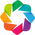

In [66]:
"""HyraxDotPlot of re-assembled microsporidian genome from Blastobasis lacticolella"""

index_file = "/lustre/scratch126/tol/teams/lawniczak/users/ak37/assemblies/ilBlaLact1/asg_course/ilBlaLact1.microsporidia.reassembly.fasta.fai"
coords_file = "/lustre/scratch126/tol/teams/lawniczak/users/ak37/assemblies/ilBlaLact1/asg_course/ilBlaLact1.microsporidia.reassembly.self.aln.coords"

xcumulative_length_dict = index_assembly(index_file)
ycumulative_length_dict = index_assembly(index_file)

plot_interactive_bokeh(coords_file=coords_file, threshold=90, x_cumulative_length_dict=xcumulative_length_dict, y_cumulative_length_dict=ycumulative_length_dict, plot_title="Reassembly of Microsporidian Genome from ilBlaLact1", output_prefix="HyraxDotPlot", plot_width=800, plot_height=600)